In [1]:
import numpy as np

from collections import Counter, defaultdict
from itertools import chain, cycle
from functools import partial

In [2]:
sample_size = 10000
products = ["A", "B", "C", "D"]
totals = [10, 5, 15, 8]
# totals = [10, 10, 10, 10]
flush_lock = 21
transition_lock = 3

In [3]:
def generate_batches(batch_size, products, totals, sample_size):
    sizes = (np.ceil(np.array(totals) / np.min(totals)) * batch_size).astype(int).tolist()
    iterators = [[product]*size for product, size in zip(products, sizes)]
    base = cycle(chain(*iterators))
    return list(dict(zip(range(sample_size), base)).values())

In [4]:
# sequence 1
denominator = sum(totals)
sequence1 = np.random.choice(products, size=sample_size, p=[t/denominator for t in totals]).tolist()

# sequence 2
sequence2 = generate_batches(20, products, totals, sample_size)

# sequence 3
sequence3 = generate_batches(40, products, totals, sample_size)

In [5]:
assert len(sequence1) == sample_size
assert len(sequence2) == sample_size
assert len(sequence3) == sample_size

In [6]:
print(Counter(sequence1))
print(Counter(sequence2))
print(Counter(sequence3))

Counter({'C': 3966, 'A': 2619, 'D': 2104, 'B': 1311})
Counter({'C': 3740, 'A': 2520, 'D': 2480, 'B': 1260})
Counter({'C': 3720, 'A': 2560, 'D': 2480, 'B': 1240})


In [7]:
def no_priority(machine_tuple, product=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return machine_tuple[0]

def sum_of_product_priority(machine_tuple, product=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return sum(machine_tuple[1].values())

def product_count_priority(machine_tuple, product=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return machine_tuple[1][product]

def double_priority(machine_tuple, product=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return (machine_tuple[1][product], sum(machine_tuple[1].values()))

In [8]:
def simulate(
    num_of_machines,
    sequence,
    products,
    totals,
    flush_lock,
    transition_lock,
    priority,
    reverse=True
):

    mix = dict(zip(products, totals))
    machines = {i: defaultdict(int) for i in range(num_of_machines)}
    flushes = defaultdict(int)
    trash = []

    for product in sequence:

        consumed = False
        for i, mach in sorted(machines.items(), key=partial(priority, product=product), reverse=reverse):
            
            # Machine is available to accept products
            machine_is_available = machines[i]["lock"] == 0
            
            # Machine has space to accept product
            product_fits = machines[i][product] < mix[product]
            
            # Complete cases for 3 binary variables
            if not consumed and machine_is_available and product_fits:
                machines[i][product] += 1
                machines[i]["lock"] = transition_lock
                consumed = True
            
            elif not consumed and machine_is_available and not product_fits:
                continue
    
            elif not consumed and not machine_is_available and product_fits:
                machines[i]["lock"] -= 1
    
            elif not consumed and not machine_is_available and not product_fits:
                machines[i]["lock"] -= 1
    
            elif consumed and machine_is_available and product_fits:
                continue
    
            elif consumed and machine_is_available and not product_fits:
                continue
    
            elif consumed and not machine_is_available and product_fits:
                machines[i]["lock"] -= 1
    
            elif consumed and not machine_is_available and not product_fits:
                machines[i]["lock"] -= 1
                
            
        # Trash un-consumed products
        if not consumed:
            trash.append(product)

        # Flush ready machines
        for j in machines:
            if all(machines[j][p] == mix[p] for p in products):
                machines[j] = defaultdict(int)
                machines[j]["lock"] = flush_lock
                flushes[j] += 1
    
    return {
        "trash": len(trash), 
        "total": len(sequence), 
        "consumed": len(sequence) - len(trash),
        "flushes": dict(flushes)
    }

In [9]:
print(simulate(5, sequence1, products, totals, flush_lock, transition_lock, no_priority, reverse=False))
print(simulate(5, sequence2, products, totals, flush_lock, transition_lock, no_priority, reverse=False))
print(simulate(5, sequence3, products, totals, flush_lock, transition_lock, no_priority, reverse=False))
print()
print(simulate(5, sequence1, products, totals, flush_lock, transition_lock, double_priority, reverse=True))
print(simulate(5, sequence2, products, totals, flush_lock, transition_lock, double_priority, reverse=True))
print(simulate(5, sequence3, products, totals, flush_lock, transition_lock, double_priority, reverse=True))

{'trash': 1419, 'total': 10000, 'consumed': 8581, 'flushes': {0: 54, 2: 50, 1: 51, 3: 42, 4: 26}}
{'trash': 1147, 'total': 10000, 'consumed': 8853, 'flushes': {0: 57, 1: 57, 2: 54, 3: 54, 4: 8}}
{'trash': 3762, 'total': 10000, 'consumed': 6238, 'flushes': {0: 34, 1: 34, 2: 31, 3: 31, 4: 30}}

{'trash': 967, 'total': 10000, 'consumed': 9033, 'flushes': {0: 47, 2: 47, 1: 47, 3: 47, 4: 47}}
{'trash': 505, 'total': 10000, 'consumed': 9495, 'flushes': {0: 50, 1: 50, 2: 50, 3: 49, 4: 49}}
{'trash': 3567, 'total': 10000, 'consumed': 6433, 'flushes': {0: 34, 1: 34, 2: 33, 3: 33, 4: 31}}


In [10]:
def averages_of_simulations(num_of_machines, sequence, products, totals, flush_lock, transition_lock, priority, reverse):
    simulations = 5

    rates = []

    for _ in range(simulations):
        data = simulate(num_of_machines, sequence, products, totals, flush_lock, transition_lock, priority, reverse)
        rates.append(data["consumed"]/data["total"])
        
    return np.mean(rates)

In [11]:
x = range(1, 15)

def get_the_ys(seq):
    return (
    [averages_of_simulations(xx, seq, products, totals, flush_lock, transition_lock, no_priority, reverse=False) for xx in x],
    [averages_of_simulations(xx, seq, products, totals, flush_lock, transition_lock, sum_of_product_priority, reverse=True) for xx in x],
    [averages_of_simulations(xx, seq, products, totals, flush_lock, transition_lock, product_count_priority, reverse=True) for xx in x],
    [averages_of_simulations(xx, seq, products, totals, flush_lock, transition_lock, sum_of_product_priority, reverse=True) for xx in x],
    )

# y1 = get_the_ys(sequence1)
# y2 = get_the_ys(sequence2)
# y3 = get_the_ys(sequence3)

In [12]:
from joblib import Parallel, delayed

results = Parallel(n_jobs=3)(delayed(get_the_ys)(i) for i in [sequence1, sequence2, sequence3])

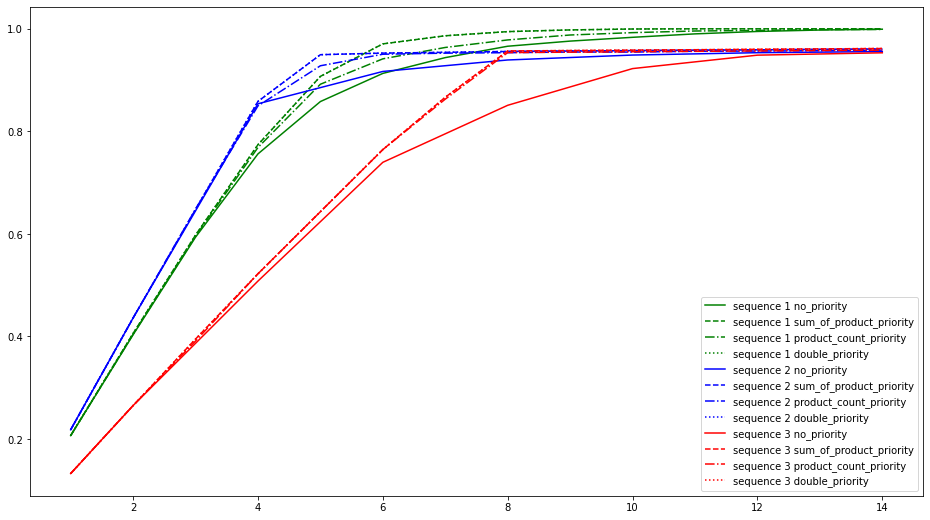

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))

plt.plot(x, results[0][0], "-g", label="sequence 1 no_priority")
plt.plot(x, results[0][1], "--g", label="sequence 1 sum_of_product_priority")
plt.plot(x, results[0][2], "-.g", label="sequence 1 product_count_priority")
plt.plot(x, results[0][3], ":g", label="sequence 1 double_priority")
# plt.plot(x, results[0][1], ":g", label="sequence 1 sum_of_product_priority")

plt.plot(x, results[1][0], "-b", label="sequence 2 no_priority")
plt.plot(x, results[1][1], "--b", label="sequence 2 sum_of_product_priority")
plt.plot(x, results[1][2], "-.b", label="sequence 2 product_count_priority")
plt.plot(x, results[1][3], ":b", label="sequence 2 double_priority")
# plt.plot(x, results[1][1], ":b", label="sequence 2 sum_of_product_priority")

plt.plot(x, results[2][0], "-r", label="sequence 3 no_priority")
plt.plot(x, results[2][1], "--r", label="sequence 3 sum_of_product_priority")
plt.plot(x, results[2][2], "-.r", label="sequence 3 product_count_priority")
plt.plot(x, results[2][3], ":r", label="sequence 3 double_priority")
# plt.plot(x, results[2][1], ":r", label="sequence 3 sum_of_product_priority")

plt.legend()
plt.show()